In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer
from transformers import (
    AutoTokenizer,
    AutoModel,
    BertForSequenceClassification,
    AutoConfig,
)
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
)
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

In [2]:
warnings.filterwarnings('ignore')

tqdm.pandas()

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)

# Check type of GPU

In [3]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1080 Ti


# Data

## Load data from local

In [4]:
data = pd.read_csv(
    '../data/external data/russian_comments_from_2ch_pikabu.csv').drop(
    'translated', axis=1)

## EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [6]:
len(data) - len(data.drop_duplicates())

0

In [7]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?\n",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)\n",1.0


<AxesSubplot:>

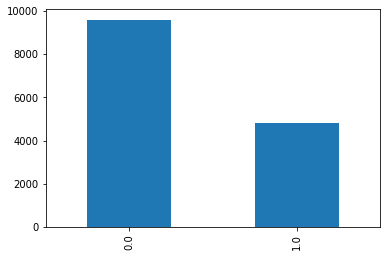

In [8]:
data['toxic'].value_counts().plot(kind='bar')

In [9]:
data_len = data['comment'].apply(lambda x: len(x.split()))

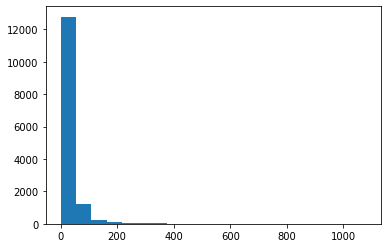

In [10]:
plt.hist(data_len, bins=20);

In [11]:
data_len_np = np.array(data_len)

np.max(data_len_np), np.min(data_len_np), np.mean(data_len_np)

(1078, 1, 27.94601720788232)

## Clean data

In [12]:
def text_preprocessing(text: str) -> str:
    """Drop thrash symbols from text

    @param text: raw text
    @return: clean text
    """
    text = re.sub(r"<[^>]*>", " ", text)
    text = re.sub(r"^\[id\d*|.*\],*\s*", "", text)
    text = re.sub(r"(&quot;)|(&lt;)|(&gt;)|(&amp;)|(&apos;)", " ", text)
    text = re.sub(r"https?://(www\.)?[-a-zA-Z0-9@:%._+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_+.~#?&/=]*)"," ", text)
    text = re.sub(r"\[[^\[\]]+\|([^\[\]]+)\]", r"\1", text)
    text = re.sub(r"(&#\d+;)", " ", text)
    text = re.sub(r"[(_#*=^/`@«»©…“•—<>\[\]\"'+%|&]", " ", text)
    text = re.sub(r"[\;:)(_#*=^/`@«»©…“•—<>\[\]\"'+%|&]", " ", text)
    text = text.replace("  ", " ")
    text = text.replace("--", " ")
    text = text.replace('\n', ' ')
    text = re.sub("\s\s+", " ", text)
    return text.strip()

In [13]:
text_preprocessing('Верблюдов-то за что? Дебилы, бл...\n')

'Верблюдов-то за что? Дебилы, бл...'

In [14]:
data['comment_clean'] = data['comment'].progress_apply(text_preprocessing)

100%|██████████| 14412/14412 [00:01<00:00, 7654.20it/s] 


In [15]:
data.head()

,comment,toxic,comment_clean
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"Верблюдов-то за что? Дебилы, бл..."
1,"Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n",1.0,"Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал."
2,Собаке - собачья смерть\n,1.0,Собаке - собачья смерть
3,"Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?\n",1.0,"Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?"
4,"тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)\n",1.0,"тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?"


## Train, valid, test split

In [16]:
data['toxic'] = data['toxic'].astype(int)

In [17]:
X = list(data['comment_clean'])
y = list(data['toxic'])

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

In [18]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.5,
    random_state=42,
    stratify=y_tmp,
)

In [19]:
len(X_train), len(X_valid), len(X_test)

(11529, 1441, 1442)

# Model

## Load BERT tokenizer, config and model

In [20]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
config = AutoConfig.from_pretrained("cointegrated/rubert-tiny")

In [21]:
model = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny", num_labels=2)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

## Check len after tokenization

In [22]:
x_train_tok = list(map(lambda x: tokenizer.tokenize(x), X_train))

Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors


In [23]:
x_train_len_tok = list(map(len, x_train_tok))

In [24]:
x_train_len_tok_np = np.array(x_train_len_tok)

(
    np.max(x_train_len_tok_np),
    np.min(x_train_len_tok_np),
    np.mean(x_train_len_tok_np),
)

(2139, 3, 58.77725735102784)

In [25]:
sum(param.numel() for param in model.parameters()) / 1e6

11.784794

In [26]:
for param in model.parameters():
    param.requires_grad = True

## Prepare data for model

In [27]:
MAX_LENGHT = 512

X_train_tok = tokenizer(
    X_train, padding=True, truncation=True, max_length=MAX_LENGHT)
X_val_tok = tokenizer(
    X_valid, padding=True, truncation=True, max_length=MAX_LENGHT)

In [28]:
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, encodings, labels=None):          
        self.encodings = encodings        
        self.labels = labels   
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.encodings["input_ids"])

In [29]:
train_dataset = Dataset(X_train_tok, y_train)
validation_dataset = Dataset(X_val_tok, y_valid)

## Train and validate model

In [30]:
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    return {
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        } 

In [31]:
# Define Trainer
N_EPOCHS = 3
BATCH_SIZE = 32


args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=100,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=N_EPOCHS,
    seed=42,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (ruamel.yaml 0.17.16 (/home/anton/.local/lib/python3.8/site-packages), Requirement.parse('ruamel.yaml<0.17.5,>=0.15.35')).


In [32]:
# Train model

trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Tp,Tn,Fp,Fn
100,No log,0.353462,0.795964,0.736515,0.765086,355,868,91,127
200,No log,0.317908,0.777567,0.848548,0.811508,409,842,117,73
300,No log,0.314806,0.824053,0.767635,0.794844,370,880,79,112
400,No log,0.303147,0.796477,0.844398,0.819738,407,855,104,75
500,0.330200,0.296991,0.822547,0.817427,0.819979,394,874,85,88
600,0.330200,0.292373,0.817814,0.838174,0.827869,404,869,90,78
700,0.330200,0.290638,0.828157,0.829876,0.829016,400,876,83,82
800,0.330200,0.310687,0.777164,0.875519,0.823415,422,838,121,60
900,0.330200,0.300009,0.813121,0.848548,0.830457,409,865,94,73
1000,0.214500,0.298851,0.816367,0.848548,0.832146,409,867,92,73


Attempted to log scalar metric eval_loss:
0.3534621298313141
Attempted to log scalar metric eval_Precision:
0.7959641255605381
Attempted to log scalar metric eval_Recall:
0.7365145228215768
Attempted to log scalar metric eval_F1:
0.7650862068965517
Attempted to log scalar metric eval_TP:
355
Attempted to log scalar metric eval_TN:
868
Attempted to log scalar metric eval_FP:
91
Attempted to log scalar metric eval_FN:
127
Attempted to log scalar metric eval_runtime:
2.815
Attempted to log scalar metric eval_samples_per_second:
511.893
Attempted to log scalar metric epoch:
0.28
Attempted to log scalar metric eval_loss:
0.31790757179260254
Attempted to log scalar metric eval_Precision:
0.7775665399239544
Attempted to log scalar metric eval_Recall:
0.8485477178423236
Attempted to log scalar metric eval_F1:
0.8115079365079365
Attempted to log scalar metric eval_TP:
409
Attempted to log scalar metric eval_TN:
842
Attempted to log scalar metric eval_FP:
117
Attempted to log scalar metric eval_

TrainOutput(global_step=1000, training_loss=0.27233750915527344, metrics={'train_runtime': 219.3165, 'train_samples_per_second': 4.938, 'total_flos': 0, 'epoch': 2.77, 'init_mem_cpu_alloc_delta': 2168438784, 'init_mem_gpu_alloc_delta': 48010752, 'init_mem_cpu_peaked_delta': 27078656, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 52166656, 'train_mem_gpu_alloc_delta': 141856768, 'train_mem_cpu_peaked_delta': 36823040, 'train_mem_gpu_peaked_delta': 5278008320})

## Save tokenizer, config and model to local

In [33]:
# Save BERT tokenizer

output_dir = '../model/tokenizer'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving tokenizer to %s" % output_dir)

tokenizer.save_pretrained(output_dir)

Saving tokenizer to ../model/tokenizer


('../model/tokenizer/tokenizer_config.json',
 '../model/tokenizer/special_tokens_map.json',
 '../model/tokenizer/vocab.txt',
 '../model/tokenizer/added_tokens.json',
 '../model/tokenizer/tokenizer.json')

In [34]:
# Save config

output_dir = '../model/tokenizer'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving tokenizer to %s" % output_dir)

config.save_pretrained(output_dir)

Saving tokenizer to ../model/tokenizer


In [35]:
# Save BERT model

trainer.save_model('../model/bert_toxic_predict')

## Validation model on test data

In [36]:
def get_prediction(text):
    inputs = tokenizer(
        [text],
        padding=True,
        truncation=True,
        max_length=MAX_LENGHT,
        return_tensors="pt",
    ).to('cuda')
    outputs = model(**inputs)
    probs = outputs[0].softmax(1).to('cpu').detach().numpy()
    proba = probs[0]
    return 1 if proba[1] > 0.5 else 0

In [37]:
test_preds = []

for i, item in enumerate(X_test):
    if i % 100 == 0:
        print(i)
    test_preds.append(get_prediction(item))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [38]:
print(f"F1-score metric on test data: {f1_score(y_test, test_preds)}")
print(f"Precision metric on test data: {precision_score(y_test, test_preds)}")
print(f"Recall metric on test data: {recall_score(y_test, test_preds)}")

F1-score metric on test data: 0.8190279214064117
Precision metric on test data: 0.8181818181818182
Recall metric on test data: 0.8198757763975155


In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()

print('Errors:')
print(f'FP: {fp}')
print(f'FN: {fn}')
print(f'TN: {tn}')
print(f'TP: {tp}')

Errors:
FP: 88
FN: 87
TN: 871
TP: 396


# Full inference

In [40]:
tokenizer_from_file = AutoTokenizer.from_pretrained('../model/tokenizer')

In [41]:
model_from_file = BertForSequenceClassification.from_pretrained(
    '../model/bert_toxic_predict', num_labels=2).to("cpu")

In [42]:
def get_prediction(text, tokenizer, model, max_length=128):
    text = text_preprocessing(text)
    inputs = tokenizer(
        [text],
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    ).to('cpu')
    outputs = model(**inputs)
    probs = outputs[0].softmax(1).to('cpu').detach().numpy()
    proba = probs[0]
    return 'Toxic' if proba[1] > 0.5 else 'Non toxic', float(proba[1])

In [43]:
get_prediction(
    text='Ну ты и баклан',
    tokenizer=tokenizer_from_file,
    model=model_from_file,
    max_length=MAX_LENGHT,
    )

('Toxic', 0.9560098648071289)